![](https://raw.githubusercontent.com/fepegar/torchio/main/docs/source/favicon_io/for_readme_2000x462.png)

[TorchIO](http://torchio.org/) is a Python library for loading, preprocessing, augmentation and sampling for multidimensional medical images in deep learning.

We can leverage the new [`RSNACervicalSpineFracture`](https://torchio.readthedocs.io/datasets.html#rsnacervicalspinefracture) class to avoid dealing with the complex [DICOM](https://www.dicomstandard.org/) and [NIfTI](https://nifti.nimh.nih.gov/) formats for medical images.

In [2]:
%pip install --quiet light-the-torch && ltt install torch
%pip install --quiet torchio
%pip install --quiet pytorch-lightning
%pip install --quiet monai


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import copy

import torchio as tio
import torch
import monai
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import time
from pathlib import Path
from datetime import datetime


torch.manual_seed(0)
num_workers = multiprocessing.cpu_count()
mpl.rcParams['figure.figsize'] = 12, 8

2022-10-21 21:10:06,890 - Created a temporary directory at /tmp/tmpjhw86ml9
2022-10-21 21:10:06,891 - Writing /tmp/tmpjhw86ml9/_remote_module_non_scriptable.py


/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


# Configure

In [78]:
BATCH_SIZE = 2
LEARNING_RATE = 0.0001
N_EPOCHS = 3
PATIENCE = 3

# Config device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset

Let's create an instance of `RSNACervicalSpineFracture`, which inherits directly from [`SubjectsDataset`](https://torchio.readthedocs.io/data/dataset.html) and indirectly from [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset).

In [6]:
# root_dir = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection'
root_dir = '/root/input/rsna-2022-cervical-spine-fracture-detection'
dataset = tio.datasets.RSNACervicalSpineFracture(root_dir, add_segmentations=True, add_bounding_boxes=True)
print('Number of subjects:', len(dataset))

  0%|          | 0/2019 [00:00<?, ?it/s]

Number of subjects: 2019


## Subject

Let's inspect the first [`Subject`](https://torchio.readthedocs.io/data/subject.html) in the dataset.

In [7]:
first_subject = dataset[1]
first_subject

Subject(Keys: ('StudyInstanceUID', 'patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'ct'); images: 1)

In [8]:
for key, value in first_subject.items():
    print(f'{key}: {value}')

StudyInstanceUID: 1.2.826.0.1.3680043.27262
patient_overall: 1
C1: 0
C2: 1
C3: 0
C4: 0
C5: 0
C6: 0
C7: 0
ct: ScalarImage(shape: (1, 512, 512, 406); spacing: (0.31, 0.31, 0.40); orientation: LPS+; dtype: torch.ShortTensor; memory: 203.0 MiB)


We can see that the patient's C1 and C2 vertebrae are fractured, according to the labels. We can also see that the CT scan is an instance of [`ScalarImage`](https://torchio.readthedocs.io/data/image.html#torchio.ScalarImage) with $512 \times 512 \times 243$ voxels, in-plane pixel spacing of 0.44 mm, slice thickness of 0.80 mm, [LPS+ orientation](https://nipy.org/nibabel/image_orientation.html) data type "short tensor" (or signed 16-bit integers) and takes 121.5 MiB of memory.

Let's take a look at the 3D image in the subject.

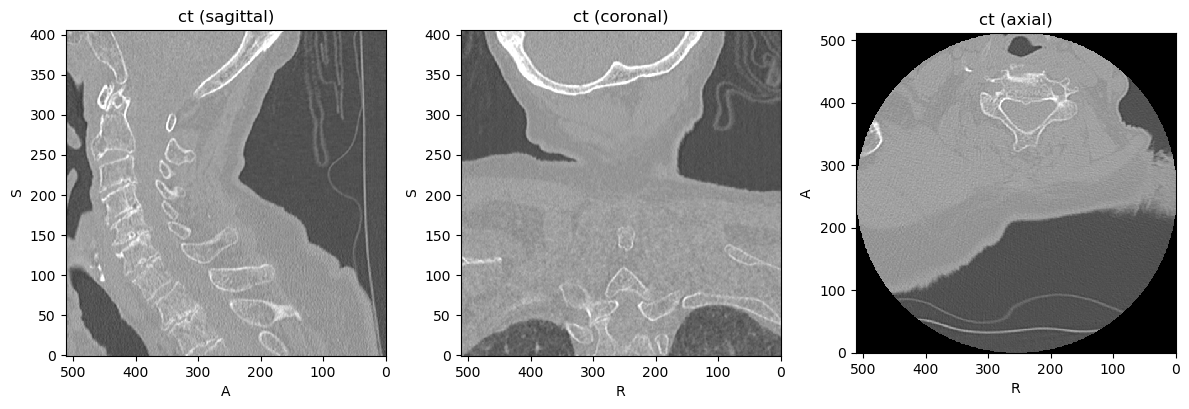

In [9]:
first_subject.plot()

The [CT scan](https://www.nhs.uk/conditions/ct-scan/) looks black where there is no reconstruction data, and the contrast in the region of interest is not great. Let's look at the intensity distribution.

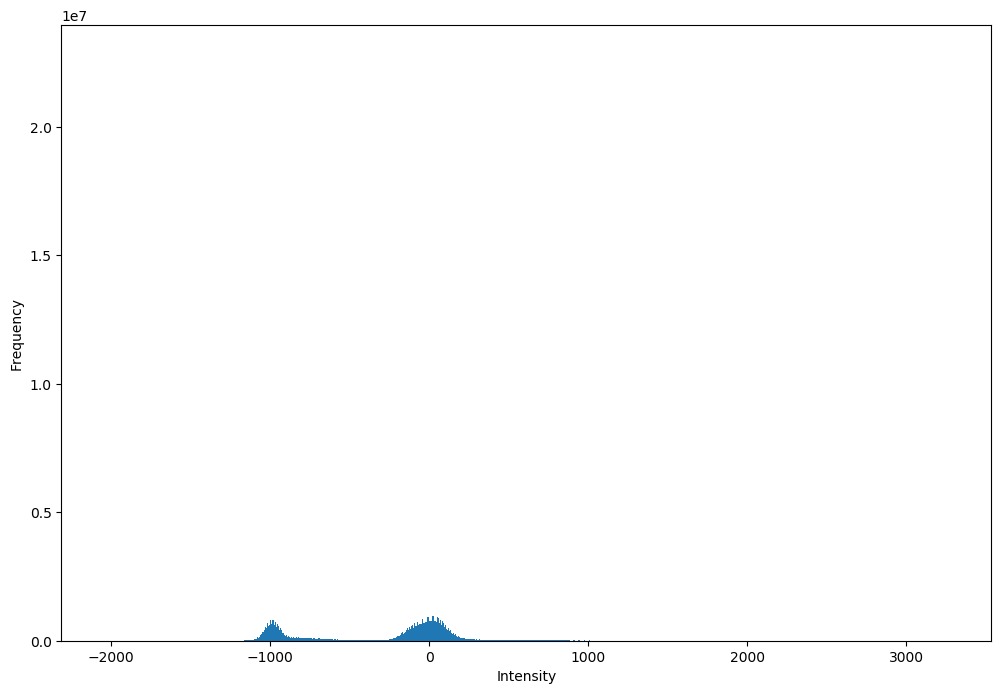

In [10]:
first_subject.ct.hist()

## Intensity preprocessing

We can look at the [Hounsfield scale](https://en.wikipedia.org/wiki/Hounsfield_scale) to keep only intensity values within a sensible range using the [`Clamp`](https://torchio.readthedocs.io/transforms/preprocessing.html#clamp) transform.

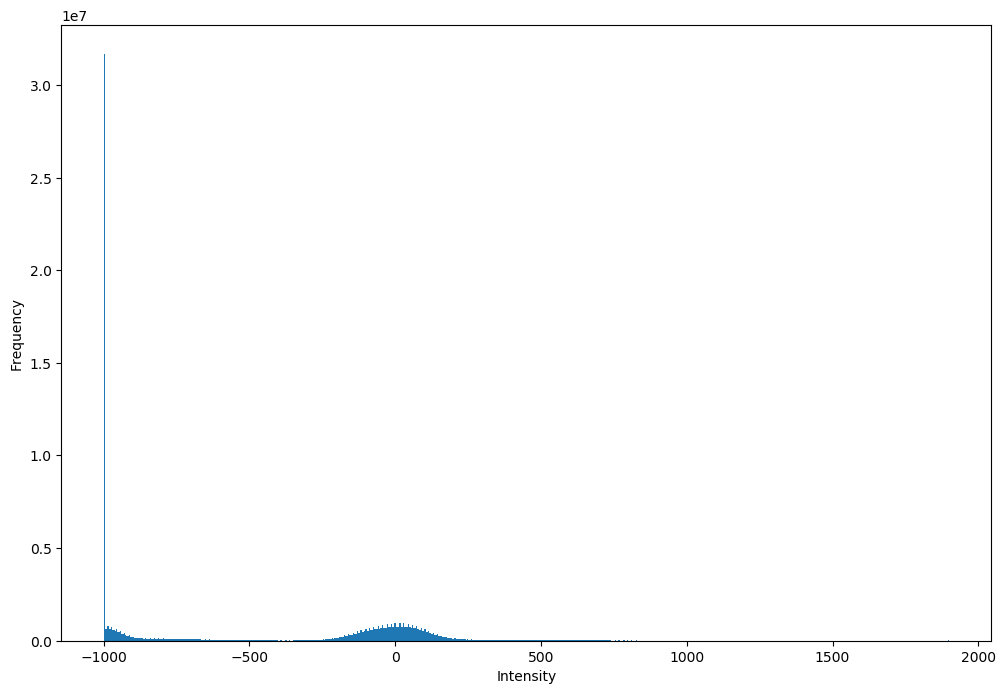

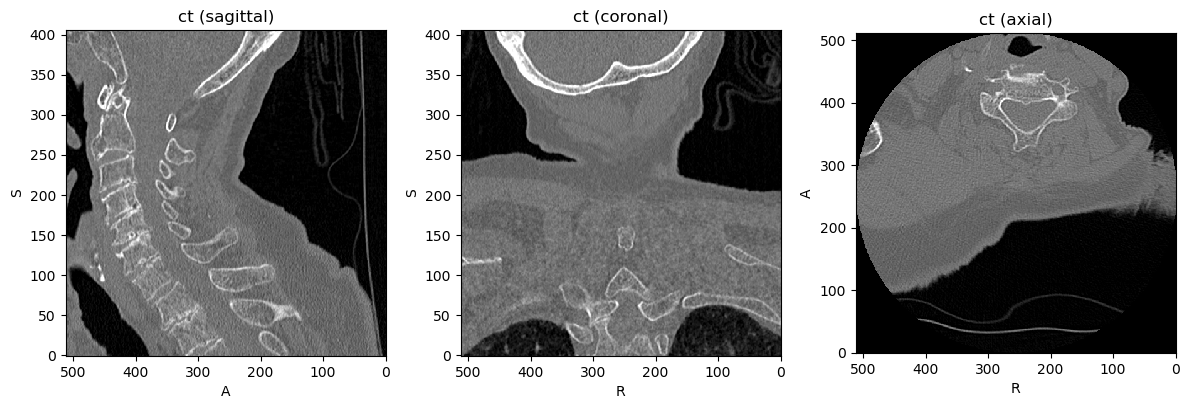

In [11]:
HOUNSFIELD_AIR, HOUNSFIELD_BONE = -1000, 1900
clamp = tio.Clamp(out_min=HOUNSFIELD_AIR, out_max=HOUNSFIELD_BONE)
first_subject_clamped = clamp(first_subject)
first_subject_clamped.ct.hist()
first_subject_clamped.plot()

That looks much better! Let's now normalize the values to [0, 1], a common practice in neural network training. We will also saturate values in the first and last half percentiles, to remove potential outliers. Clamping and rescaling can be concatenated using [`Compose`](https://torchio.readthedocs.io/transforms/augmentation.html#compose) to create an intensity preprocessing transform.

In [12]:
rescale = tio.RescaleIntensity(percentiles=(0.5, 99.5))
preprocess_intensity = tio.Compose([
    clamp,
    rescale,
])

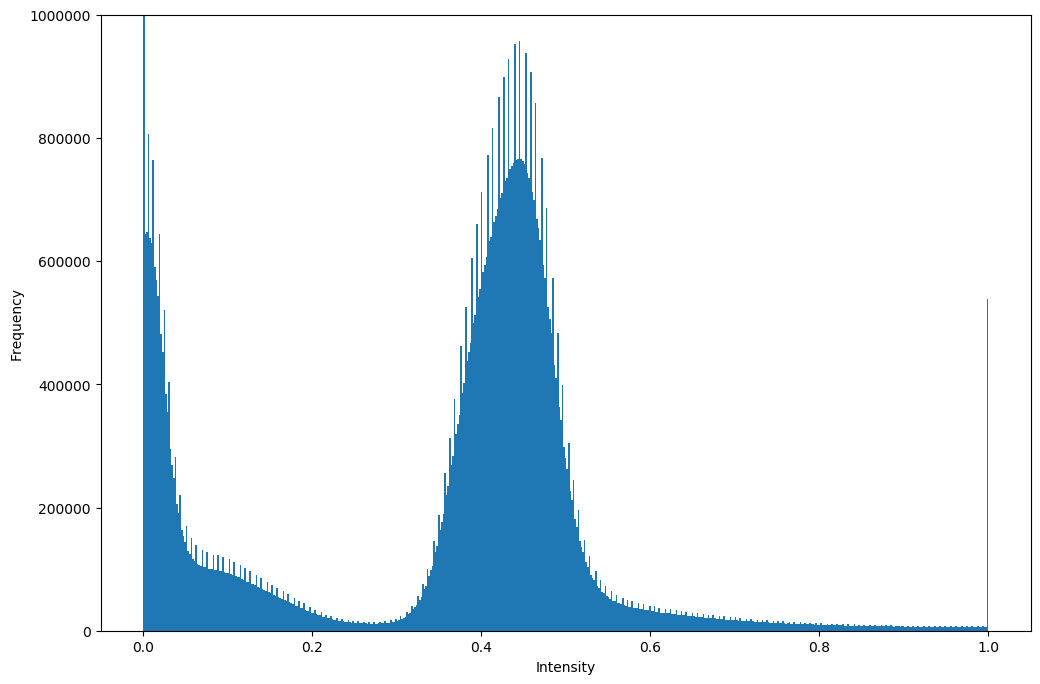

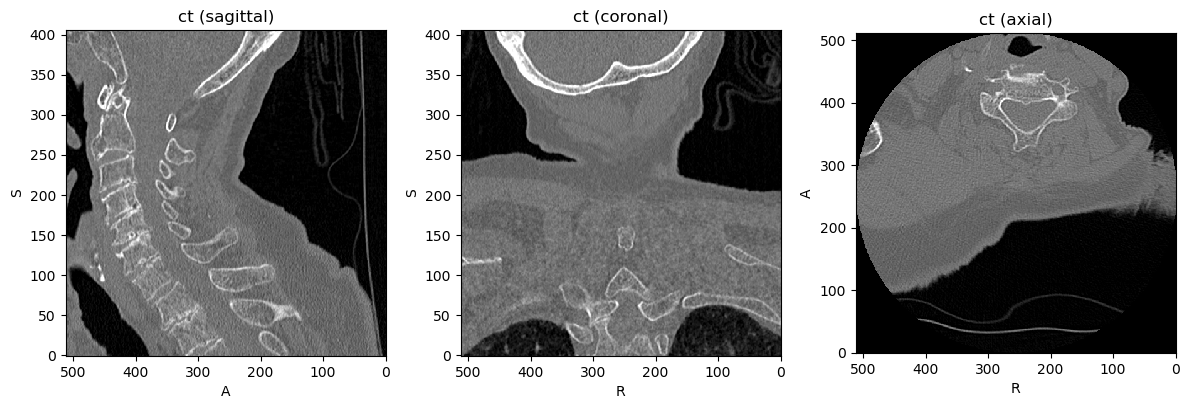

In [13]:
first_subject_preprocessed = preprocess_intensity(first_subject)
first_subject_preprocessed.ct.hist(show=False), plt.ylim(0, 1e6)
first_subject_preprocessed.plot()

Let's look for a subject with an associated segmentation. We will use the [`dry_iter` method of `SubjectsDataset`](https://torchio.readthedocs.io/data/dataset.html#torchio.data.SubjectsDataset.dry_iter) as we don't want to load any data here.

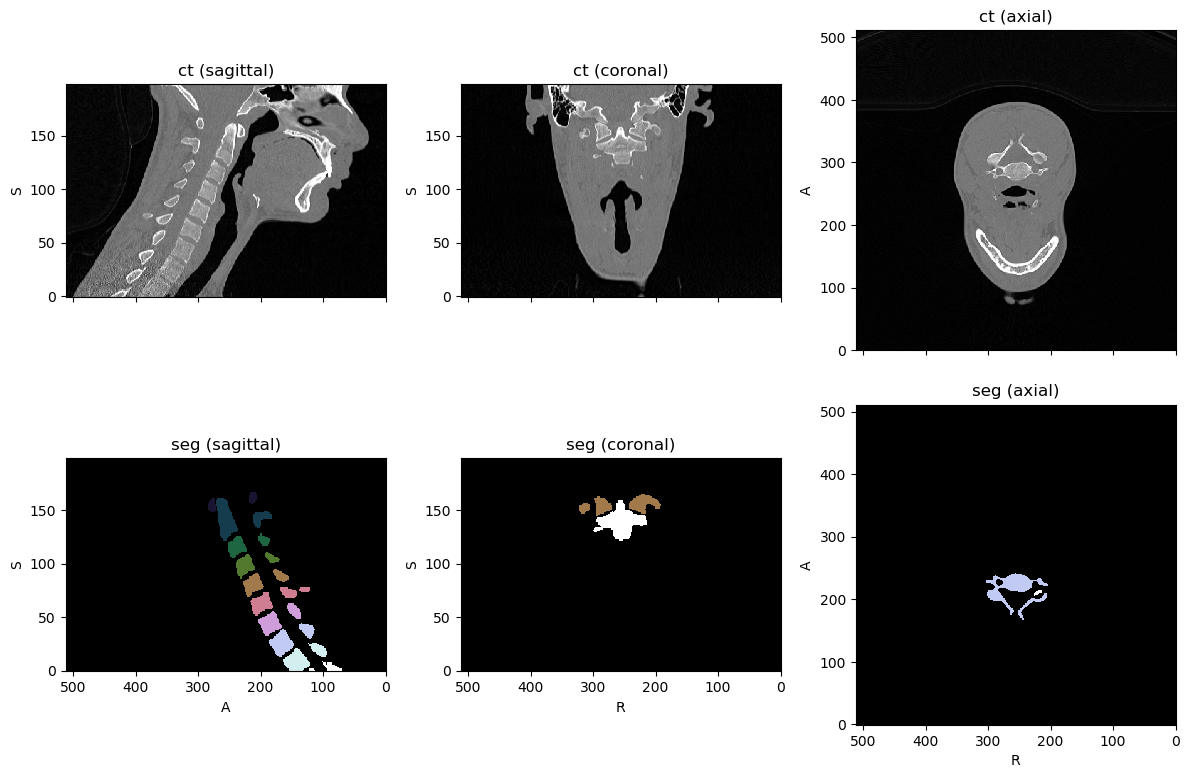

In [14]:
for subject in dataset.dry_iter():
    if 'seg' in subject:
        subject_with_seg = subject
        break
subject_with_seg.plot(reorient=False)

## Spatial preprocessing

The CT scan and the corresponding segmentation are not aligned! Let's look at their orientations.

In [15]:
print('CT orientation:', subject_with_seg.ct.orientation)
print('Segmentation orientation:', subject_with_seg.seg.orientation)

CT orientation: ('L', 'P', 'S')
Segmentation orientation: ('L', 'A', 'S')


It looks like voxels along the second spatial dimension grow towards the back (Posterior) in the CT and towards the front (Anterior) in the segmentation. That's why the images looked flipped with respect to the [coronal](https://en.wikipedia.org/wiki/Coronal_plane) plane.

We can normalize the orientation (to RAS+) using [`ToCanonical`](https://torchio.readthedocs.io/transforms/preprocessing.html#tocanonical). Also, as the resolution is quite high, we will downsample to a sensible value (1 mm isotropic) for faster computations using [`Resample`](https://torchio.readthedocs.io/transforms/preprocessing.html#resample). These two transforms are implemented on top of [NiBabel](https://nipy.org/nibabel/) and [SimpleITK](https://simpleitk.org/), respectively.

As before, we use `Compose` to concatenate preprocessing transforms.

In [16]:
normalize_orientation = tio.ToCanonical()
downsample = tio.Resample(1)
crop = tio.CropOrPad((224,224,224))
multiple_shape = tio.EnsureShapeMultiple(8)  # for the U-Net

In [17]:

preprocess_spatial = tio.Compose([
    normalize_orientation,
    downsample,
    crop,
    multiple_shape
])

preprocess = tio.Compose([
    preprocess_intensity,
    preprocess_spatial,
])

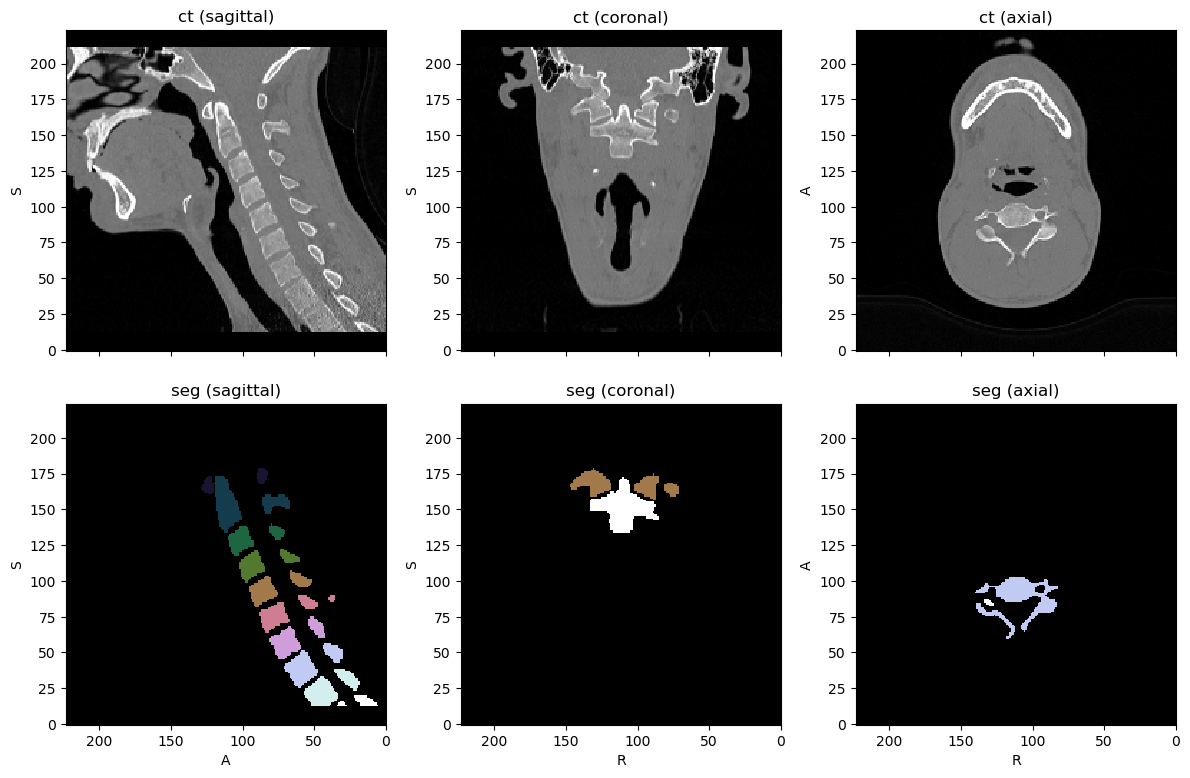

In [18]:
subject_with_seg_preprocessed = preprocess(subject_with_seg)
subject_with_seg_preprocessed.plot(reorient=False)

That's better! We actually didn't need to pass `reorient=False` to the `plot` method, as all that does is apply `ToCanonical` internally, which we have already done.

## Data augmentation

There are also many [augmentation transforms](https://torchio.readthedocs.io/transforms/augmentation.html) available in TorchIO. Let's compose some appropriate ones. If we were using MRI, we should definitely leverage some of the [MRI k-space artifact simulation transforms](https://torchio.readthedocs.io/transforms/augmentation.html#randommotion). Here, we will use simpler ones.

In [19]:
augment = tio.Compose([
    tio.RandomAnisotropy(p=0.25),
    tio.RandomAffine(),
    tio.RandomFlip(),
    tio.RandomNoise(p=0.25),
    tio.RandomGamma(p=0.5),
])

In this case, we always apply an affine (anisotropic scaling + rotation) transform. The others are applied with a probability of 0.25 or 0.5.

Internally, [`RandomFlip`](https://torchio.readthedocs.io/transforms/augmentation.html#randomflip) uses 0.5). By default, flipping is applied only around the sagittal plane, i.e., left-right. But if you feel adventurous, feel free to explore other axes as well!

Let's set our training and validation transforms. We want augmentation during training only; our validation transform is simply our deterministic preprocessing.

In [20]:
train_transform = tio.Compose([
    preprocess,
    augment,
])
val_transform = preprocess

Let's look at some preprocessed and randomly augmented variations of our subject.

In [21]:
# for _ in range(5):
#     subject_with_seg_augmented = train_transform(subject_with_seg)
#     subject_with_seg_augmented.plot()

Intensity transforms are only applied to instances of `ScalarImage`, whereas spatial transforms are applied also to instances of [`LabelMap`](https://torchio.readthedocs.io/data/image.html#torchio.LabelMap). Of course, the same random parameters for spatial transforms are applied to all images within the same subject!

# Add label to dataset

In [22]:
train_df = pd.read_csv("/root/input/rsna-2022-cervical-spine-fracture-detection/train.csv")
no_segs_dataset = tio.datasets.RSNACervicalSpineFracture(root_dir)

  0%|          | 0/2019 [00:00<?, ?it/s]

In [23]:
# Dataset for train/valid sets only
class RSNADataset(Dataset):
    # Initialise
    def __init__(self, dataset = no_segs_dataset, df_table = train_df, transform=None):
        super().__init__()
        
        self.df_table = df_table.reset_index(drop=True)
        self.transform = transform
        self.set_transform(transform)
        self.targets = ['C1','C2','C3','C4','C5','C6','C7','patient_overall']
        # Populate labels
        self.labels = self.df_table[self.targets].values
        
    def set_transform(self, transform= None):
        """Set the :attr:`transform` attribute.

        Args:
            transform: Callable object, typically an subclass of
                :class:`torchio.transforms.Transform`.
        """
        if transform is not None and not callable(transform):
            message = (
                'The transform must be a callable object,'
                f' but it has type {type(transform)}'
            )
            raise ValueError(message)
        self.transform = transform
        
    def __getitem__(self, index):
        vol = dataset[index]['ct']
        if self.transform:
            vol = self.transform(vol)
        return vol, self.labels[index]
    
    # Length of dataset
    def __len__(self):
        return len(self.df_table['StudyInstanceUID'])


In [24]:
no_seg_set = RSNADataset(no_segs_dataset, train_df)

Let's use 80% of our data for training and 20% for validation.

In [25]:
train_to_val_ratio = 0.2
num_subjects = len(dataset)
num_train_subjects = int(train_to_val_ratio * num_subjects)
num_val_subjects = num_subjects - num_train_subjects
print('Number of subjects for training:  ', num_train_subjects)
print('Number of subjects for validation: ', num_val_subjects)

Number of subjects for training:   403
Number of subjects for validation:  1616


We will assume we won't need the segmentations or bounding boxes during training. We create a new instance of `RSNACervicalSpineFracture` and random split it between training and validation sets using PyTorch.

In [26]:
train_set, val_set = torch.utils.data.random_split(no_seg_set, [num_train_subjects, num_val_subjects])

In [27]:
train_set[0]

(ScalarImage(shape: (1, 512, 512, 361); spacing: (0.35, 0.35, 0.40); orientation: LPS+; dtype: torch.ShortTensor; memory: 180.5 MiB),
 array([1, 1, 0, 0, 0, 0, 0, 1]))

In [28]:
val_set[0]

(ScalarImage(shape: (1, 512, 512, 293); spacing: (0.25, 0.25, 0.62); orientation: LPS+; dtype: torch.IntTensor; memory: 293.0 MiB),
 array([0, 0, 0, 0, 0, 0, 0, 0]))

We use the training and validation transforms compute above for our training and validation sets.

In [29]:
# Both subsets share the "dataset" attribute, so the last statement would
# overwrite the previous one unless we deep-copy one of the subsets
val_set = copy.deepcopy(val_set)
train_set.dataset.set_transform(train_transform)
val_set.dataset.set_transform(val_transform)

In [30]:
# train_set[0]

(ScalarImage(shape: (1, 224, 224, 224); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 42.9 MiB),
 array([1, 1, 0, 0, 0, 0, 0, 1]))

In [31]:
# val_set[0]

(ScalarImage(shape: (1, 224, 224, 224); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 42.9 MiB),
 array([0, 0, 0, 0, 0, 0, 0, 0]))

Let's look at some of the images in our training set. They are randomly transformed by our `train_transform`.

In [ ]:
# for i in range(1):
#     train_set[i].plot()

Let's now look at some of the images in the validation set, which are not augmented (only preprocessed).

In [32]:
# for i in range(1):
#     val_set[i].plot()

## Experiment with Small Sample

In [69]:
from torch.utils.data import Subset
num_subjects = len(dataset)
dataset_indices = list(range(num_subjects))
np.random.shuffle(dataset_indices)

n_train_sample = 20
n_val_sample = 10

train_idx, val_idx = torch.Tensor(dataset_indices[:n_train_sample]), torch.Tensor(dataset_indices[n_train_sample:(n_train_sample+n_val_sample)])

train_indices = train_idx.nonzero().reshape(-1)
val_indices = val_idx.nonzero().reshape(-1)

train_subset = Subset(train_set, train_indices)
val_subset = Subset(val_set, val_indices)

train_loader = DataLoader(dataset=train_subset, shuffle=False, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)

print(len(train_loader))
print(len(val_loader))

10
5


# Patch-based pipeline

In [ ]:
patch_size = 24
samples_per_volume = 5
max_queue_length = 300
sampler = tio.data.UniformSampler(patch_size)

patches_training_set = tio.Queue(
    subjects_dataset=train_subset,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=val_subset,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader_patches = torch.utils.data.DataLoader(
    patches_training_set, batch_size=BATCH_SIZE)

validation_loader_patches = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=BATCH_SIZE)

In [ ]:
one_batch = next(iter(training_loader_patches))
k = int(patch_size // 4)
batch_mri = one_batch['mri'][tio.DATA][..., k]
batch_label = one_batch['brain'][tio.DATA][:, 1:, ..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_patches.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=training_batch_size,
    normalize=True,
    scale_each=True,
)
display.Image(image_path)

# Torch dataloaders

In [61]:
# train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
# valid_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=False)

# Sanity Check

In [39]:
# Experiment with architecture
arr = np.ones((4,1,224,224,224))
x = torch.tensor(arr, dtype=torch.float32)

conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=0)
pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
norm1 = nn.BatchNorm3d(num_features=16)
conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
norm2 = nn.BatchNorm3d(num_features=32)
conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
norm3 = nn.BatchNorm3d(num_features=64)
avg = nn.AdaptiveAvgPool3d((7, 1, 1))
flat = nn.Flatten()
relu = nn.ReLU()
lin1 = nn.Linear(in_features=32*13*13*13, out_features=256)
lin2 = nn.Linear(in_features=256, out_features=8)

out = conv1(x)
out = relu(out)
out = pool(out)
out = norm1(out)
print(out.shape)

out = conv2(out)
out = relu(out)
out = pool(out)
out = norm2(out)
print(out.shape)

out = conv3(out)
out = relu(out)
out = pool(out)
out = norm3(out)
print(out.shape)

out = avg(out)
print(out.shape)
out = flat(out)
print(out.shape)

torch.Size([4, 16, 109, 109, 109])
torch.Size([4, 32, 53, 53, 53])
torch.Size([4, 64, 25, 25, 25])
torch.Size([4, 64, 7, 1, 1])
torch.Size([4, 448])


# Model

In [70]:
# 3D convolutional neural network
class Conv3DNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Layers
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=0)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.norm1 = nn.BatchNorm3d(num_features=16)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.norm2 = nn.BatchNorm3d(num_features=32)
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.norm3 = nn.BatchNorm3d(num_features=64)
        self.avg = nn.AdaptiveAvgPool3d((7, 1, 1))
        self.flat = nn.Flatten()
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(in_features=448, out_features=128)
        self.lin2 = nn.Linear(in_features=128, out_features=8)
        
    def forward(self, x):
        # Conv block 1
        out = self.conv1(x)
        out = self.relu(out)
        out = self.pool(out)
        out = self.norm1(out)
        
        # Conv block 2
        out = self.conv2(out)
        out = self.relu(out)
        out = self.pool(out)
        out = self.norm2(out)
        
        # Conv block 3
        out = self.conv3(out)
        out = self.relu(out)
        out = self.pool(out)
        out = self.norm3(out)
        
        # Average & flatten
        out = self.avg(out)
        out = self.flat(out)
        
        # Fully connected layer
        out = self.lin1(out)
        out = self.relu(out)
        
        # Output layer (no sigmoid needed)
        out = self.lin2(out)
        
        return out

model = Conv3DNet().to(device)

In [71]:
loss_fn = nn.BCEWithLogitsLoss(reduction='none')

competition_weights = {
    '-' : torch.tensor([1, 1, 1, 1, 1, 1, 1, 7], dtype=torch.float, device=device),
    '+' : torch.tensor([2, 2, 2, 2, 2, 2, 2, 14], dtype=torch.float, device=device),
}

# y_hat.shape = (batch_size, num_classes)
# y.shape = (batch_size, num_classes)

# with row-wise weights normalization (https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/344565)
def competiton_loss_row_norm(y_hat, y):
    loss = loss_fn(y_hat, y.to(y_hat.dtype))
    weights = y * competition_weights['+'] + (1 - y) * competition_weights['-']
    loss = (loss * weights).sum(axis=1)
    w_sum = weights.sum(axis=1)
    loss = torch.div(loss, w_sum)
    return loss.mean()

In [72]:
# Adam optimiser
optimiser = optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimiser, T_max=N_EPOCHS)

# Training

In [73]:
# for epoch in tqdm(range(N_EPOCHS)):
#     for imgs, labels in train_dataloader:
#         # Send to device
#         imgs = imgs['data']
#         labels = labels
#         print(imgs.shape)
#         print(labels.shape)

  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224, 224])
torch.Size([2, 8])
torch.Size([2, 1, 224, 224, 224])
torch.Size([2, 8])
torch.Size([2, 1, 224, 224, 224])
torch.Size([2, 8])


  0%|          | 0/2 [01:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
loss_hist = []
val_loss_hist = []
patience_counter = 0
best_val_loss = np.inf

# Loop over epochs
for epoch in tqdm(range(N_EPOCHS)):
    loss_acc = 0
    val_loss_acc = 0
    train_count = 0
    valid_count = 0
    
    # Loop over batches
    for imgs, labels in train_loader:
        # Send to device
        imgs = imgs['data'].to(device)
        labels = labels.to(device)
        
       # Forward pass
        preds = model(imgs)
        L = competiton_loss_row_norm(preds, labels)

        # Backprop
        L.backward()

        # Update parameters
        optimiser.step()

        # Zero gradients
        optimiser.zero_grad()
        
        # Track loss
        loss_acc += L.detach().item()
        train_count += 1
    
    # Update learning rate
    scheduler.step()

    # Don't update weights
    with torch.no_grad():
        # Validate
        for val_imgs, val_labels in val_loader:
            # Reshape
            val_imgs = val_imgs['data'].to(device)
            val_labels = val_labels.to(device)

            # Forward pass
            val_preds = model(val_imgs)
            val_L = competiton_loss_row_norm(val_preds,val_labels)
            
            # Track loss
            val_loss_acc += val_L.item()
            valid_count += 1
    
    # Save loss history
    loss_hist.append(loss_acc/train_count)
    val_loss_hist.append(val_loss_acc/valid_count)

    #print loss
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{N_EPOCHS}, loss {loss_acc/train_count:.5f}, val_loss {val_loss_acc/valid_count:.5f}')
    
    # Save model (& early stopping)
    if (val_loss_acc/valid_count) < best_val_loss:
        best_val_loss = val_loss_acc/valid_count
        patience_counter=0
        print('Valid loss improved --> saving model')
        torch.save({
                    'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimiser_state_dict': optimiser.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'loss': loss_acc/train_count,
                    'val_loss': val_loss_acc/valid_count,
                    }, "Conv3DNet.pt")
    else:
        patience_counter+=1
        
        if patience_counter==PATIENCE:
            break
            
print('')
print('Training complete!')

  0%|          | 0/3 [00:00<?, ?it/s]

# Learning Curve

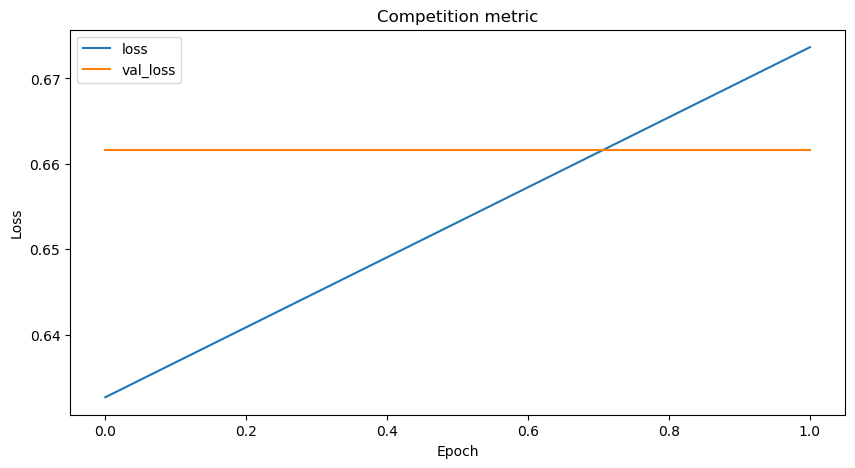

In [76]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(loss_hist, c='C0', label='loss')
plt.plot(val_loss_hist, c='C1', label='val_loss')
plt.title('Competition metric')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()